# **TRAIN MODEL**

## ***NHẬT KÝ***
+ 31/10 Train thử nghiệm 1

In [21]:
import numpy as np
import pandas as pd
import joblib
from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns
# --- CÀI ĐẶT CHO BIỂU ĐỒ ---
# Cài đặt style và font chữ để hiển thị đẹp hơn
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Segoe UI' # Hoặc 'Arial', 'Helvetica'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 7)

import os
import logging
import time
from datetime import datetime

#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Các công cụ lựa chọn đặc trưng
from sklearn.feature_selection import RFECV, SelectFromModel
# Khai báo thư viện cho mô hình phân loại đa lớp
from sklearn.linear_model import LogisticRegression# Mô hình tuyến tính
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis# Phân tích tuyến tính
from sklearn.tree import DecisionTreeClassifier# Cây quyết định
from sklearn.neighbors import KNeighborsClassifier# Mô hình khoảng cách (k-láng giềng)
from sklearn.svm import SVC# Mô hình SVM (máy vector hỗ trợ)
from sklearn.naive_bayes import GaussianNB# Mô hình xác suất
from sklearn.neural_network import MLPClassifier# Mạng nơ-ron đơn giản (đa lớp)
from sklearn.ensemble import RandomForestClassifier#rừng ngẫu nhiên
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import warnings
# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [22]:
# =============================================================================
# CÁC HÀM TRỰC QUAN HÓA
# =============================================================================
def plot_model_comparison(df, title):
    """Vẽ biểu đồ cột so sánh độ chính xác của các mô hình."""
    plt.figure(figsize=(12, 8))
    bars = sns.barplot(x='Accuracy', y='Mô hình', data=df.sort_values('Accuracy', ascending=False), palette='viridis')
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Accuracy Score', fontsize=12)
    plt.ylabel('Mô hình', fontsize=12)
    plt.xlim(0.7, 1.0) # Điều chỉnh giới hạn để biểu đồ rõ ràng hơn
    
    # Thêm nhãn số liệu trên các cột
    for bar in bars.patches:
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
                 f'{bar.get_width():.4f}', 
                 va='center')
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_feature_importance(importances_df):
    """Vẽ biểu đồ cột thể hiện độ quan trọng của các đặc trưng."""
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importances_df, palette='plasma')
    plt.title('Độ quan trọng của các đặc trưng', fontsize=16, weight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_performance_improvement(df, model_name):
    """Vẽ biểu đồ đường thể hiện sự cải thiện của một mô hình qua các bước."""
    model_results = df[df['Mô hình'].str.contains(model_name)].copy()
    # Sắp xếp theo thứ tự logic
    stage_order = ['Baseline', 'Lựa chọn đặc trưng', 'Điều chỉnh siêu tham số']
    model_results['Thử nghiệm'] = pd.Categorical(model_results['Thử nghiệm'], categories=stage_order, ordered=True)
    model_results.sort_values('Thử nghiệm', inplace=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(model_results['Thử nghiệm'], model_results['Accuracy'], marker='o', linestyle='--', color='b')
    
    # Thêm nhãn số liệu
    for i, row in model_results.iterrows():
        plt.text(row['Thử nghiệm'], row['Accuracy'] + 0.001, f"{row['Accuracy']:.4f}")
        
    plt.title(f'Sự cải thiện hiệu suất của mô hình {model_name}', fontsize=16, weight='bold')
    plt.xlabel('Giai đoạn thử nghiệm', fontsize=12)
    plt.ylabel('Accuracy Score', fontsize=12)
    plt.ylim(model_results['Accuracy'].min() - 0.01, model_results['Accuracy'].max() + 0.01)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_bar_comparison(df, x_col, y_col, title, palette='viridis'):
    """Hàm vẽ biểu đồ cột đa năng."""
    plt.figure(figsize=(14, 8))
    df_sorted = df.sort_values(x_col, ascending=False)
    bars = sns.barplot(x=x_col, y=y_col, data=df_sorted, palette=palette)
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    plt.xlim(max(0.7, df_sorted[x_col].min() - 0.05), df_sorted[x_col].max() + 0.05)
    for bar in bars.patches:
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_performance_journey(df, title):
    """Vẽ biểu đồ đường thể hiện hành trình cải thiện của các mô hình."""
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df, x='Giai đoạn', y='Accuracy', hue='Mô hình', marker='o', style='Mô hình', markersize=10, dashes=False)
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel('Giai đoạn Tối ưu hóa', fontsize=14)
    plt.ylabel('Accuracy Score', fontsize=14)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(title='Mô hình', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_detailed_model_metrics(df):
    """
    Vẽ biểu đồ cột nhóm để so sánh chi tiết các chỉ số của từng mô hình.
    """
    # Chuẩn bị dữ liệu: Chuyển từ format "wide" sang "long" để dễ vẽ
    metrics_to_plot = [
        'Accuracy', 
        #'F1-score(Weighted)', 
        'F1-score', 
        'Precision', 
        'Recall'
    ]
    df_melted = df.melt(id_vars='Mô hình', value_vars=metrics_to_plot, var_name='Chỉ số', value_name='Giá trị')

    plt.figure(figsize=(20, 10)) # Kích thước lớn hơn cho biểu đồ phức tạp
    ax = sns.barplot(data=df_melted, x='Mô hình', y='Giá trị', hue='Chỉ số', palette='Set2')
    
    plt.title('So sánh chi tiết hiệu suất các mô hình cơ sở', fontsize=20, weight='bold')
    plt.xlabel('Mô hình', fontsize=14)
    plt.ylabel('Điểm số', fontsize=14)
    plt.xticks(rotation=45, ha='right') # Xoay nhãn trục x để không bị chồng chéo
    plt.ylim(0, 1.1) # Đặt giới hạn trục y từ 0 đến 1.1 để có không gian cho nhãn
    plt.legend(title='Chỉ số', fontsize=12)

    # Thêm nhãn số liệu trên mỗi cột
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_before_after_comparison(df):
    """
    Vẽ biểu đồ cột nhóm kép để so sánh hiệu suất "Trước" (Baseline) và "Sau" (Tuned)
    của các mô hình trên nhiều chỉ số.
    """
    # Chuẩn bị dữ liệu: Chuyển từ format "wide" sang "long"
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    df_melted = df.melt(id_vars=['Mô hình', 'Giai đoạn'], value_vars=metrics_to_plot, 
                        var_name='Chỉ số', value_name='Giá trị')

    plt.figure(figsize=(22, 12))
    
    # Dùng catplot để tạo các biểu đồ con cho mỗi mô hình, giúp dễ so sánh hơn
    g = sns.catplot(data=df_melted, x='Chỉ số', y='Giá trị', hue='Giai đoạn', col='Mô hình', 
                    kind='bar', palette={'Baseline': 'skyblue', 'Tuned': 'navy'}, height=6, aspect=0.8)

    g.fig.suptitle('So sánh hiệu suất "Trước" và "Sau" khi tối ưu hóa', y=1.03, fontsize=22, weight='bold')
    g.set_axis_labels("Chỉ số", "Điểm số")
    g.set_titles("Mô hình: {col_name}")
    g.set(ylim=(0, 1))

    # 2. Tự thêm lại ghi chú vào vị trí mong muốn
    plt.legend(title='Giai đoạn', loc='upper right')

    # Thêm nhãn số liệu
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.4f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=10)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    plt.close()



In [23]:
# =============================================================================
# 1. TẢI DỮ LIỆU ĐÃ CHUẨN BỊ
# =============================================================================
print("--- BƯỚC 1: TẢI DỮ LIỆU ĐÃ CHUẨN BỊ ---")

save_dir = "Data_clean_v2"
npz_path = os.path.join(save_dir, 'model_data.npz')

try:
    data = np.load(npz_path, allow_pickle=True)
    # Lấy tên cột từ file train_final.csv để đảm bảo chính xác
    train_csv_path = os.path.join(save_dir, 'train_cleaned.csv')
    df_train_final = pd.read_csv(train_csv_path)
    feature_columns = [col for col in df_train_final.columns if col not in ['Survived']]
    
    X_train = pd.DataFrame(data['X_train'], columns=feature_columns)
    X_validation = pd.DataFrame(data['X_validation'], columns=feature_columns)
    y_train = data['y_train']
    y_validation = data['y_validation']
    
    print(f"Tải dữ liệu thành công. Kích thước X_train: {X_train.shape}, X_validation: {X_validation.shape}")
except Exception as e:
    print(f"Lỗi khi tải dữ liệu: {e}. Hãy đảm bảo bạn đã chạy pipeline chuẩn bị dữ liệu trước.")
    exit()


--- BƯỚC 1: TẢI DỮ LIỆU ĐÃ CHUẨN BỊ ---
Tải dữ liệu thành công. Kích thước X_train: (623, 21), X_validation: (268, 21)



--- BƯỚC 2: TÌM TOP 3 MÔ HÌNH CƠ SỞ TỐT NHẤT ---
--- Logistic Regression ---
  Accuracy: 0.8284
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.8284 | Recall: 0.8284 | F1-score: 0.8284

--- Support Vector Machine ---
  Accuracy: 0.8097
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.8130 | Recall: 0.8097 | F1-score: 0.8108

--- Decision Tree ---
  Accuracy: 0.7463
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.7536 | Recall: 0.7463 | F1-score: 0.7485

--- Random Forest ---
  Accuracy: 0.7910
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.7889 | Recall: 0.7910 | F1-score: 0.7888

--- Gradient Boosting ---
  Accuracy: 0.8097
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.8084 | Recall: 0.8097 | F1-score: 0.8088

--- KNN ---
  Accuracy: 0.7761
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.7770 | Recall: 0.7761 | F1-score: 0.7765

--- Naive Bayes ---
  Accuracy: 0.7463
  Chi tiết cho lớp 'Sống sót' (1):
    Precision: 0.7859 | Recall: 0.7463 | F1-score: 0.7494

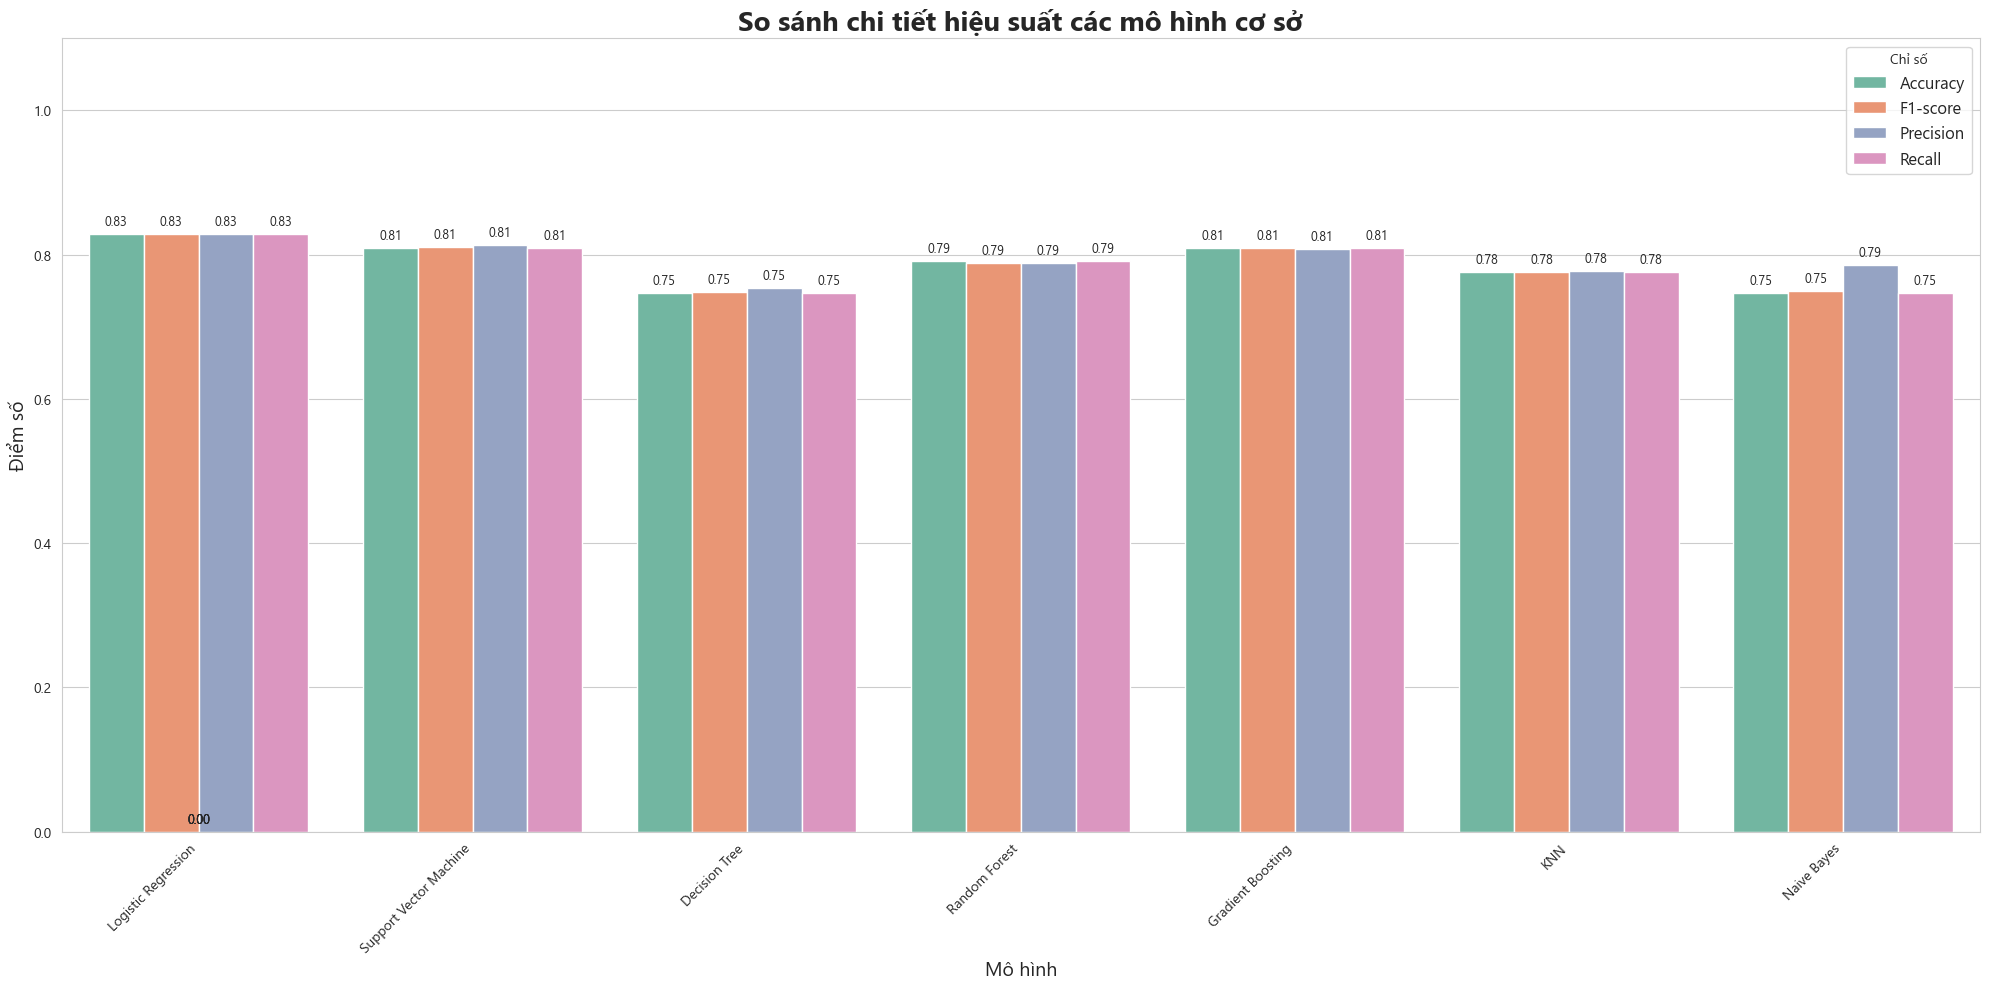

In [24]:
# =============================================================================
# 2. VÒNG 1: SƠ LOẠI - TÌM TOP 3 MÔ HÌNH CƠ SỞ TỐT NHẤT
# =============================================================================
print("\n--- BƯỚC 2: TÌM TOP 3 MÔ HÌNH CƠ SỞ TỐT NHẤT ---")
models = {
    "Logistic Regression": LogisticRegression(random_state=42), "Support Vector Machine": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42), "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42), "KNN": KNeighborsClassifier(), "Naive Bayes": GaussianNB()
}
all_results = []
baseline_results = []
for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_validation)

    '''
    # Lấy báo cáo dưới dạng dictionary để dễ dàng truy cập
    report = classification_report(y_validation, y_pred, output_dict=True, zero_division=0)


     # Lấy các chỉ số quan trọng. Chúng ta quan tâm đến việc dự đoán đúng người sống sót (lớp '1')
    accuracy = report['accuracy']
    precision_class1 = report['1']['precision']
    recall_class1 = report['1']['recall']
    f1_score_class1 = report['1']['f1-score']
    f1_weighted = report['weighted avg']['f1-score'] # Dùng chỉ số này để chọn mô hình tốt nhất
    '''
    # 3. Tính toán các chỉ số
    accuracy = accuracy_score(y_validation, y_pred)
    precision_class1 = precision_score(y_validation, y_pred, average="weighted")
    recall_class1 = recall_score(y_validation, y_pred, average="weighted")
    f1_score_class1 = f1_score(y_validation, y_pred, average="weighted")


    baseline_results.append({
        "Mô hình": name,
        "Accuracy": accuracy,
        "Precision": precision_class1,
        "Recall": recall_class1,
        "F1-score": f1_score_class1,
        #"F1-score(Weighted)": f1_weighted
    })
    
    # In ra output chi tiết hơn
    print(f"--- {name} ---")
    print(f"  Accuracy: {accuracy:.4f}")
    #print(f"  F1-score (Weighted Avg): {f1_weighted:.4f}")
    print(f"  Chi tiết cho lớp 'Sống sót' (1):")
    print(f"    Precision: {precision_class1:.4f} | Recall: {recall_class1:.4f} | F1-score: {f1_score_class1:.4f}\n")

baseline_df = pd.DataFrame(baseline_results)
top_3_model_names = baseline_df.sort_values(by="Accuracy", ascending=False).head(3)['Mô hình'].tolist()

print("--- KẾT QUẢ SO SÁNH CÁC MÔ HÌNH CƠ SỞ ---")
print(baseline_df.to_string())

print(f"\n=> Top 3 mô hình tiềm năng nhất: {top_3_model_names}")
plot_detailed_model_metrics(baseline_df)

In [25]:
# =============================================================================
# 3. VÒNG 2 & 3: TỐI ƯU ĐẶC TRƯNG VÀ SIÊU THAM SỐ CHO TOP 3
# =============================================================================
print("\n--- BƯỚC 3 & 4: TỐI ƯU HÓA TOP 3 MÔ HÌNH ---")

# Scale dữ liệu trước để tái sử dụng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

param_grids = {
    "Random Forest": {'model__n_estimators': [100, 200, 300], 'model__max_depth': [5, 10, 15], 'model__min_samples_leaf': [1, 2]},
    "Gradient Boosting": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.05, 0.1], 'model__max_depth': [3, 4, 5]},
    "Support Vector Machine": {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf', 'poly']},
    "Logistic Regression": {'model__C': [0.1, 1, 10], 'model__solver': ['liblinear']},
    "KNN": {'model__n_neighbors': [3, 5, 7, 9, 11]}
}

final_results = []
tuned_results = []
for model_name in top_3_model_names:
    print(f"\n--- Đang tối ưu hóa cho: {model_name} ---")
    
    # --- 3a. TÌM BỘ ĐẶC TRƯNG TỐI ƯU BẰNG RFECV ---
    print(f"[1] Tìm bộ đặc trưng tối ưu bằng RFECV...")
     # Nếu là SVC, dùng phiên bản kernel='linear' cho việc lựa chọn đặc trưng
    if model_name == "Support Vector Machine":
        model_for_fs = SVC(kernel='linear', random_state=42)
        print("   -> (Lưu ý: Dùng SVC với kernel='linear' cho RFECV)")
    else:
        model_for_fs = models[model_name]
        
    rfecv_selector = RFECV(estimator=model_for_fs, step=1, cv=5, scoring='f1_weighted', n_jobs=-1)
    rfecv_selector.fit(X_train_scaled, y_train)
    
    optimal_features_mask = rfecv_selector.support_
    optimal_feature_names = X_train.columns[optimal_features_mask]
    print(f"   => RFECV đã chọn ra {len(optimal_feature_names)} đặc trưng tối ưu.")
    
    X_train_optimal = X_train[optimal_feature_names]
    X_validation_optimal = X_validation[optimal_feature_names]
    
    # --- 3b. TINH CHỈNH SIÊU THAM SỐ VỚI BỘ ĐẶC TRƯNG TỐI ƯU ---
    print(f"[2] Tinh chỉnh siêu tham số bằng GridSearchCV...")
    param_grid = param_grids.get(model_name)
    
    if param_grid:
        pipeline_for_tuning = Pipeline([('scaler', StandardScaler()), ('model', models[model_name])])
        grid_search = GridSearchCV(pipeline_for_tuning, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X_train_optimal, y_train)
        
        print(f"   => Tham số tốt nhất: {grid_search.best_params_}")
        
        best_model_tuned = grid_search.best_estimator_
        y_pred_tuned = best_model_tuned.predict(X_validation_optimal)
        accuracy_tuned = accuracy_score(y_validation, y_pred_tuned)
        precision_tuned = precision_score(y_validation, y_pred_tuned, average="weighted")
        recall_tuned = recall_score(y_validation, y_pred_tuned, average="weighted")
        f1_tuned = f1_score(y_validation, y_pred_tuned, average="weighted")

        tuned_results.append({
        "Mô hình": model_name,
        "Accuracy": accuracy_tuned,
        "Precision": precision_tuned,
        "Recall": recall_tuned,
        "F1-score": f1_tuned,
        #"F1-score(Weighted)": f1_weighted
    })
        
        print(f"   => Accuracy cuối cùng sau khi tối ưu: {accuracy_tuned:.4f}")
        all_results.append({"Giai đoạn": "Tuned (Final)", "Mô hình": model_name, "Accuracy": accuracy_tuned, "Precision": precision_tuned, "Recall": recall_tuned, "F1_tuned": f1_tuned})
        final_results.append({"Mô hình": model_name, "Accuracy": accuracy_tuned})

            # In ra output chi tiết hơn
        print(f"--- {model_name} ---")
        print(f"  Accuracy: {accuracy_tuned:.4f}")
        print(f"    Precision: {precision_tuned:.4f} | Recall: {recall_tuned:.4f} | F1-score: {f1_tuned:.4f}\n")
    else:
        print(f"   => Bỏ qua GridSearchCV vì không có param_grid cho {model_name}.")

tuned_df = pd.DataFrame(tuned_results)

print("--- KẾT QUẢ SO SÁNH CÁC MÔ HÌNH TỐI ƯU SIÊU THAM SỐ ---")
print(tuned_df.to_string())



--- BƯỚC 3 & 4: TỐI ƯU HÓA TOP 3 MÔ HÌNH ---

--- Đang tối ưu hóa cho: Logistic Regression ---
[1] Tìm bộ đặc trưng tối ưu bằng RFECV...
   => RFECV đã chọn ra 13 đặc trưng tối ưu.
[2] Tinh chỉnh siêu tham số bằng GridSearchCV...
   => Tham số tốt nhất: {'model__C': 0.1, 'model__solver': 'liblinear'}
   => Accuracy cuối cùng sau khi tối ưu: 0.8097
--- Logistic Regression ---
  Accuracy: 0.8097
    Precision: 0.8101 | Recall: 0.8097 | F1-score: 0.8099


--- Đang tối ưu hóa cho: Support Vector Machine ---
[1] Tìm bộ đặc trưng tối ưu bằng RFECV...
   -> (Lưu ý: Dùng SVC với kernel='linear' cho RFECV)
   => RFECV đã chọn ra 10 đặc trưng tối ưu.
[2] Tinh chỉnh siêu tham số bằng GridSearchCV...
   => Tham số tốt nhất: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
   => Accuracy cuối cùng sau khi tối ưu: 0.8060
--- Support Vector Machine ---
  Accuracy: 0.8060
    Precision: 0.8077 | Recall: 0.8060 | F1-score: 0.8066


--- Đang tối ưu hóa cho: Gradient Boosting ---
[1] Tìm


--- BƯỚC 5: KẾT QUẢ CUỐI CÙNG VÀ TRỰC QUAN HÓA ---

Bảng so sánh chi tiết hiệu suất 'Trước' và 'Sau' khi tối ưu:
                  Mô hình  Accuracy  Precision    Recall  F1-score Giai đoạn
0       Gradient Boosting  0.809701   0.808396  0.809701  0.808755  Baseline
1       Gradient Boosting  0.794776   0.792954  0.794776  0.793298     Tuned
2     Logistic Regression  0.828358   0.828358  0.828358  0.828358  Baseline
3     Logistic Regression  0.809701   0.810066  0.809701  0.809872     Tuned
4  Support Vector Machine  0.809701   0.812951  0.809701  0.810766  Baseline
5  Support Vector Machine  0.805970   0.807651  0.805970  0.806628     Tuned


<Figure size 2200x1200 with 0 Axes>

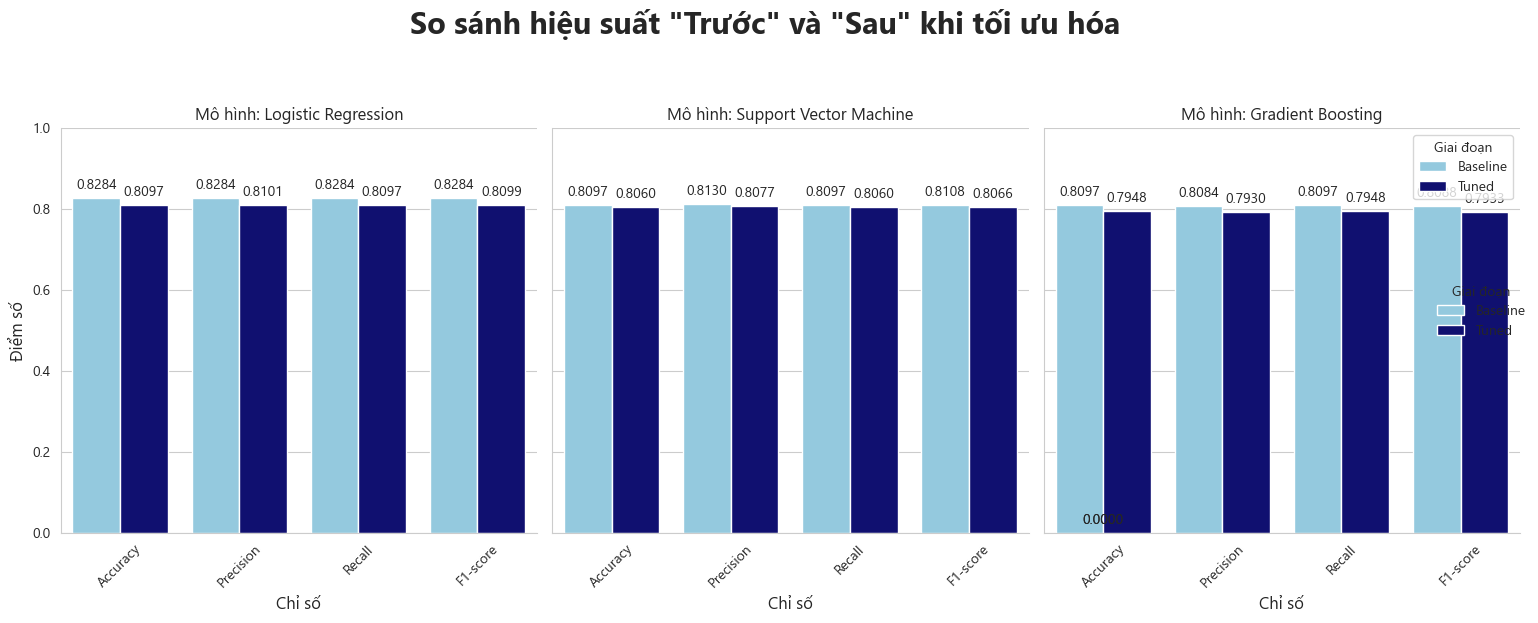


Bảng tóm tắt hành trình cải thiện của Top 3 mô hình:
Giai đoạn               Tuned (Final)
Mô hình                              
Gradient Boosting            0.794776
Logistic Regression          0.809701
Support Vector Machine       0.805970


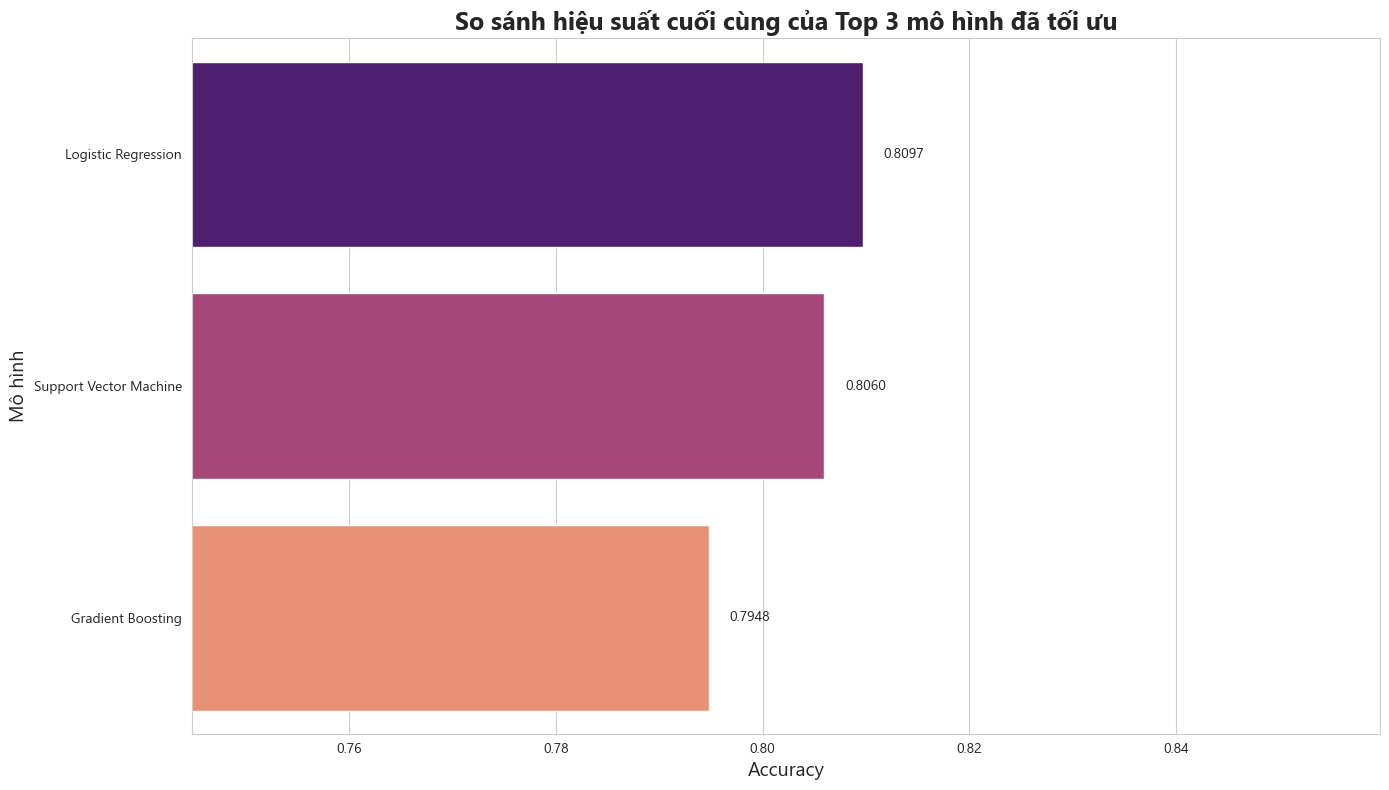

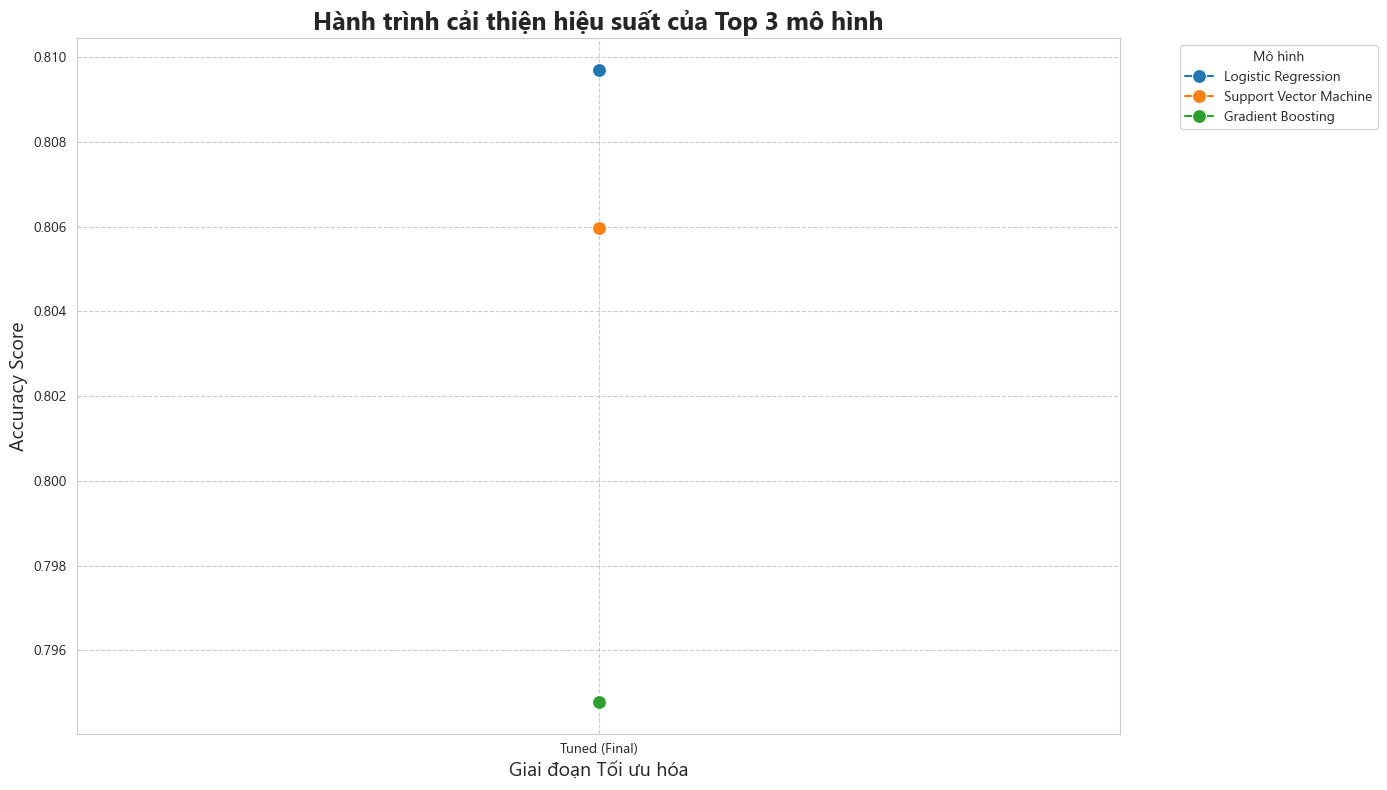

In [26]:
# =============================================================================
# 5. VÒNG CHUNG KẾT: SO SÁNH VÀ TRỰC QUAN HÓA
# =============================================================================
print("\n--- BƯỚC 5: KẾT QUẢ CUỐI CÙNG VÀ TRỰC QUAN HÓA ---")

# Lấy kết quả baseline của top 3
baseline_top3_df = baseline_df[baseline_df['Mô hình'].isin(top_3_model_names)].copy()
baseline_top3_df['Giai đoạn'] = 'Baseline'

# Lấy kết quả đã tối ưu
tuned_df = pd.DataFrame(tuned_results)
tuned_df['Giai đoạn'] = 'Tuned'

# Kết hợp lại thành một DataFrame duy nhất
comparison_df = pd.concat([baseline_top3_df, tuned_df], ignore_index=True)

# In bảng so sánh chi tiết
print("\nBảng so sánh chi tiết hiệu suất 'Trước' và 'Sau' khi tối ưu:")
# Sắp xếp để dễ nhìn hơn
comparison_df_sorted = comparison_df.sort_values(by=['Mô hình', 'Giai đoạn']).reset_index(drop=True)
print(comparison_df_sorted.to_string())

# Trực quan hóa kết quả so sánh
plot_before_after_comparison(comparison_df)

# --- Bảng tổng kết hành trình ---
journey_df = pd.DataFrame(all_results)
journey_df = journey_df[journey_df['Mô hình'].isin(top_3_model_names)]
journey_df['Giai đoạn'] = pd.Categorical(journey_df['Giai đoạn'], categories=['Baseline', 'Tuned (Final)'], ordered=True)
print("\nBảng tóm tắt hành trình cải thiện của Top 3 mô hình:")
try:
    pivot_table = journey_df.pivot(index='Mô hình', columns='Giai đoạn', values='Recall', )
    print(pivot_table)
except ValueError as e:
    print(f"Không thể tạo pivot table: {e}")
    print("Hiển thị dữ liệu gốc của journey_df:")
    print(journey_df)
    
# --- Biểu đồ so sánh hiệu suất cuối cùng của Top 3 ---
final_df = pd.DataFrame(final_results)
plot_bar_comparison(final_df, x_col='Accuracy', y_col='Mô hình', title='So sánh hiệu suất cuối cùng của Top 3 mô hình đã tối ưu', palette='magma')

# --- Biểu đồ đường thể hiện hành trình ---
plot_performance_journey(journey_df, 'Hành trình cải thiện hiệu suất của Top 3 mô hình')

# ***HẾT***


--- BƯỚC 2: SO SÁNH CÁC MÔ HÌNH CƠ SỞ ---
Mô hình: Logistic Regression       | Accuracy: 0.8284
Mô hình: Support Vector Machine    | Accuracy: 0.8097
Mô hình: Decision Tree             | Accuracy: 0.7463
Mô hình: Random Forest             | Accuracy: 0.7910
Mô hình: Gradient Boosting         | Accuracy: 0.8097
Mô hình: KNN                       | Accuracy: 0.7761
Mô hình: Naive Bayes               | Accuracy: 0.7463

=> Mô hình cơ sở tốt nhất là: Logistic Regression


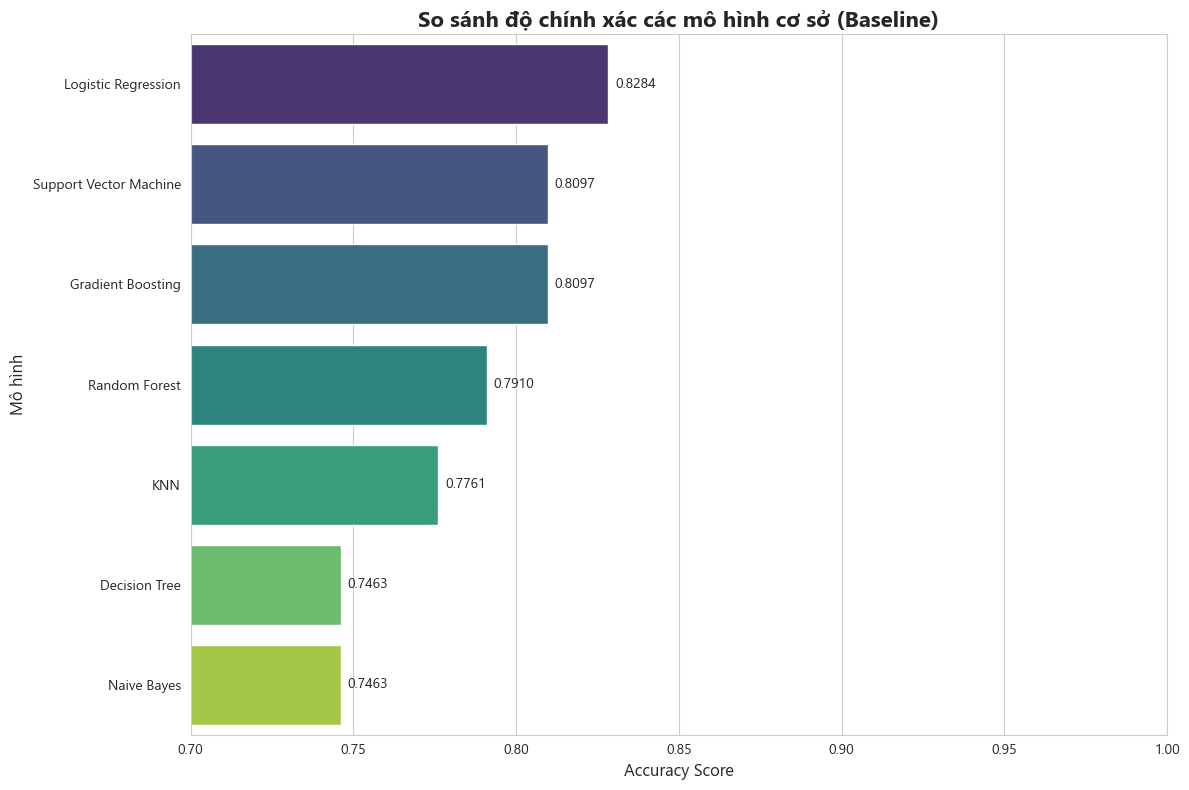

In [27]:
# =============================================================================
# 2. SO SÁNH CÁC MÔ HÌNH CƠ SỞ (BASELINE)
# =============================================================================
print("\n--- BƯỚC 2: SO SÁNH CÁC MÔ HÌNH CƠ SỞ ---")

# Các mô hình nhạy cảm với feature scaling cần StandardScaler
# Tree-based models thì không cần, nhưng dùng chung pipeline cho nhất quán
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = []

for name, model in models.items():
    # Tạo pipeline: Scale dữ liệu -> Huấn luyện mô hình
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Huấn luyện
    pipeline.fit(X_train, y_train)
    
    # Dự đoán trên tập validation
    y_pred = pipeline.predict(X_validation)
    
    # Đánh giá
    accuracy = accuracy_score(y_validation, y_pred)
    
    results.append({
        "Thử nghiệm": "Baseline",
        "Mô hình": name,
        "Accuracy": accuracy
    })
    print(f"Mô hình: {name:<25} | Accuracy: {accuracy:.4f}")

# Tìm mô hình cơ sở tốt nhất
baseline_df = pd.DataFrame(results)
best_baseline_model_name = baseline_df.sort_values(by="Accuracy", ascending=False).iloc[0]['Mô hình']
print(f"\n=> Mô hình cơ sở tốt nhất là: {best_baseline_model_name}")

# Trực quan hóa kết quả baseline
plot_model_comparison(baseline_df, 'So sánh độ chính xác các mô hình cơ sở (Baseline)')



--- BƯỚC 3: SO SÁNH VỚI LỰA CHỌN ĐẶC TRƯNG ---
Mô hình Logistic Regression không có feature_importances_. Dùng Random Forest để minh họa.

Độ quan trọng của các đặc trưng:
        feature  importance
0   PassengerId    0.156244
3          Fare    0.153058
2           Age    0.152353
6      Sex_male    0.120189
10     Title_Mr    0.119142
4    FamilySize    0.066840
1        Pclass    0.051534
11    Title_Mrs    0.031090
20       Deck_U    0.031052
5      HasCabin    0.029961
9    Title_Miss    0.026884
8    Embarked_S    0.016348
7    Embarked_Q    0.009952
16       Deck_E    0.007986
12   Title_Rare    0.006887
14       Deck_C    0.006437
15       Deck_D    0.006180
13       Deck_B    0.003583
17       Deck_F    0.002503
18       Deck_G    0.001149
19       Deck_T    0.000629


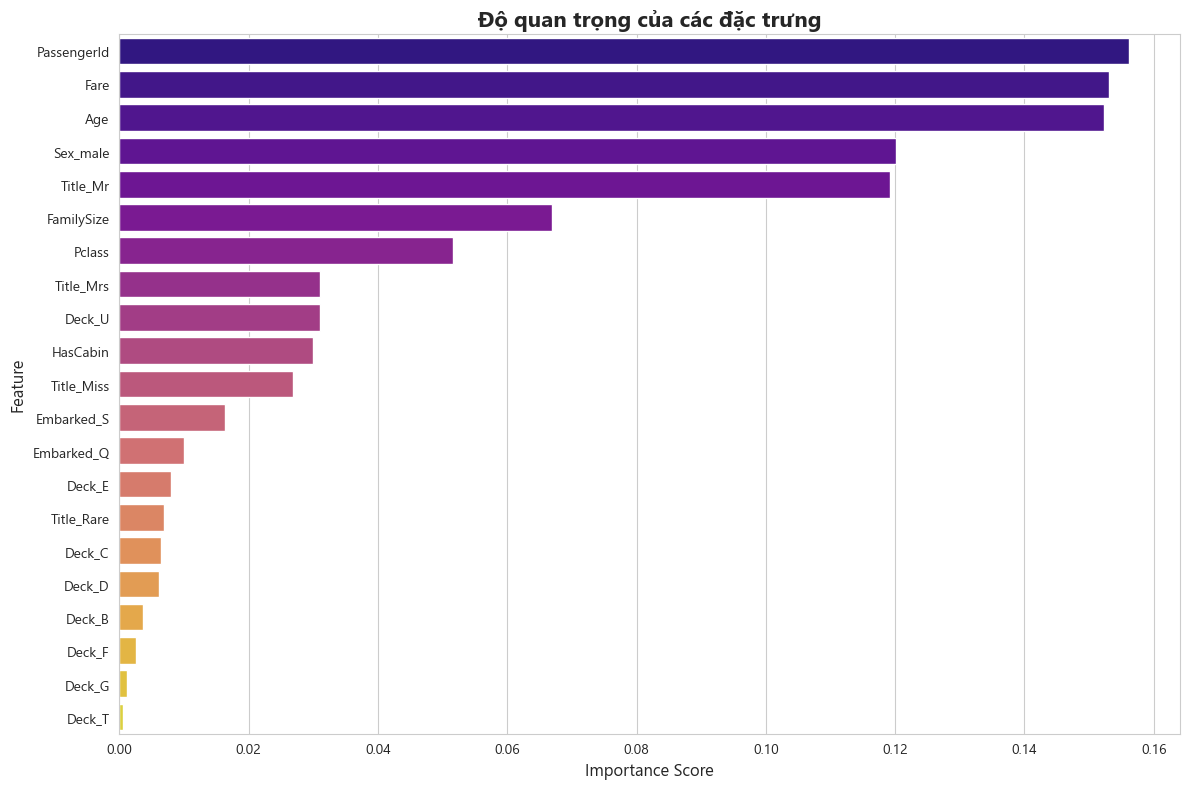


Thử nghiệm loại bỏ 2 đặc trưng yếu nhất: ['Deck_G', 'Deck_T']
Accuracy của 'Logistic Regression' sau khi lựa chọn đặc trưng: 0.8246


In [28]:
# =============================================================================
# 3. SO SÁNH VỚI LỰA CHỌN ĐẶC TRƯNG (FEATURE SELECTION)
# =============================================================================
print("\n--- BƯỚC 3: SO SÁNH VỚI LỰA CHỌN ĐẶC TRƯNG ---")
best_model_for_fs = models.get(best_baseline_model_name, RandomForestClassifier(random_state=42))
if not hasattr(best_model_for_fs, 'feature_importances_'):
    print(f"Mô hình {best_baseline_model_name} không có feature_importances_. Dùng Random Forest để minh họa.")
    best_model_for_fs = RandomForestClassifier(random_state=42)

best_model_for_fs.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model_for_fs.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nĐộ quan trọng của các đặc trưng:")
print(feature_importances)
plot_feature_importance(feature_importances)

features_to_drop = feature_importances.tail(2)['feature'].tolist()
print(f"\nThử nghiệm loại bỏ 2 đặc trưng yếu nhất: {features_to_drop}")
X_train_selected = X_train.drop(columns=features_to_drop)
X_validation_selected = X_validation.drop(columns=features_to_drop)

pipeline_fs = Pipeline([('scaler', StandardScaler()), ('model', models[best_baseline_model_name])])
pipeline_fs.fit(X_train_selected, y_train)
y_pred_fs = pipeline_fs.predict(X_validation_selected)
accuracy_fs = accuracy_score(y_validation, y_pred_fs)

results.append({"Thử nghiệm": "Lựa chọn đặc trưng", "Mô hình": best_baseline_model_name, "Accuracy": accuracy_fs})
print(f"Accuracy của '{best_baseline_model_name}' sau khi lựa chọn đặc trưng: {accuracy_fs:.4f}")



--- BƯỚC 3: SO SÁNH CÁC PHƯƠNG PHÁP LOẠI BỎ ĐẶC TRƯNG ---
Sử dụng mô hình 'Logistic Regression' để đánh giá các phương pháp lựa chọn đặc trưng.

[1] Phương pháp: Manual Selection (dựa trên Importance)


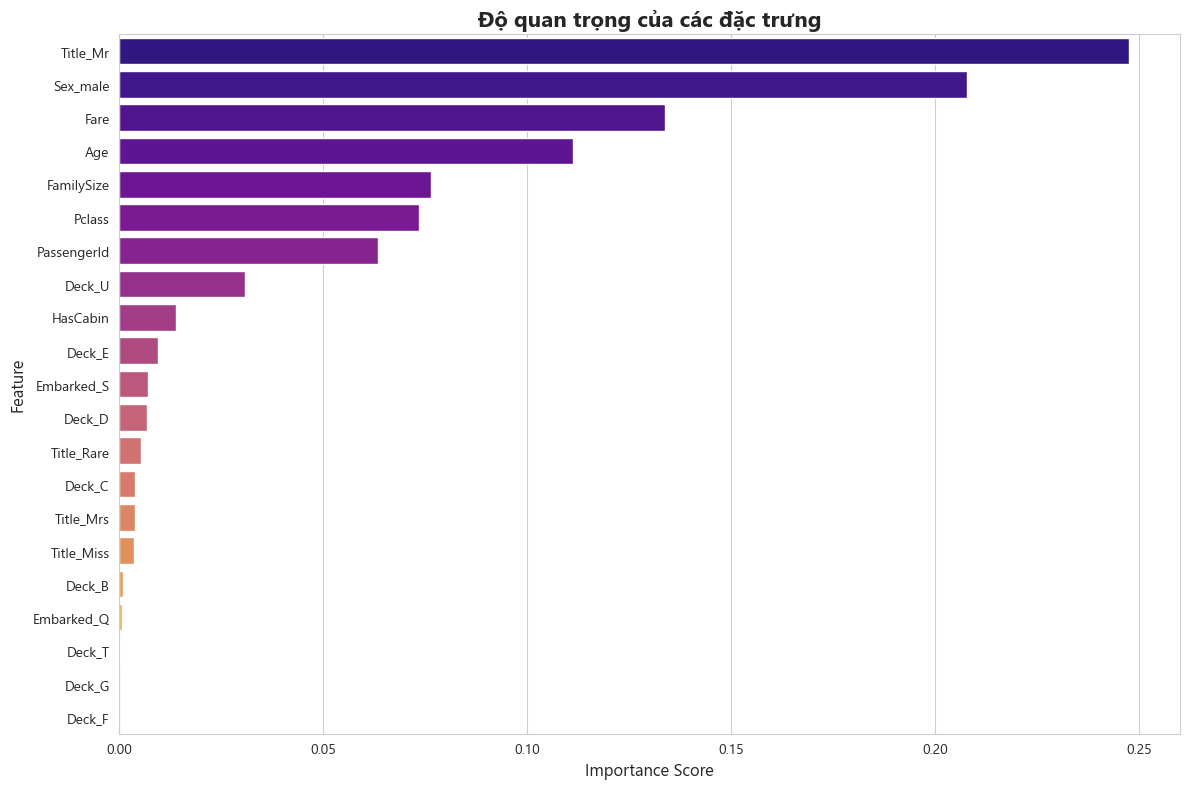

Accuracy với Manual Selection: 0.8321 (18 features)

[2] Phương pháp: RFECV (Tìm số features tối ưu tự động)
RFECV tìm thấy số features tối ưu là: 12
Accuracy với RFECV: 0.8358 (12 features)

[3] Phương pháp: SelectFromModel (với L1/Lasso)
SelectFromModel giữ lại 13 features.
Accuracy với SelectFromModel: 0.8321 (13 features)


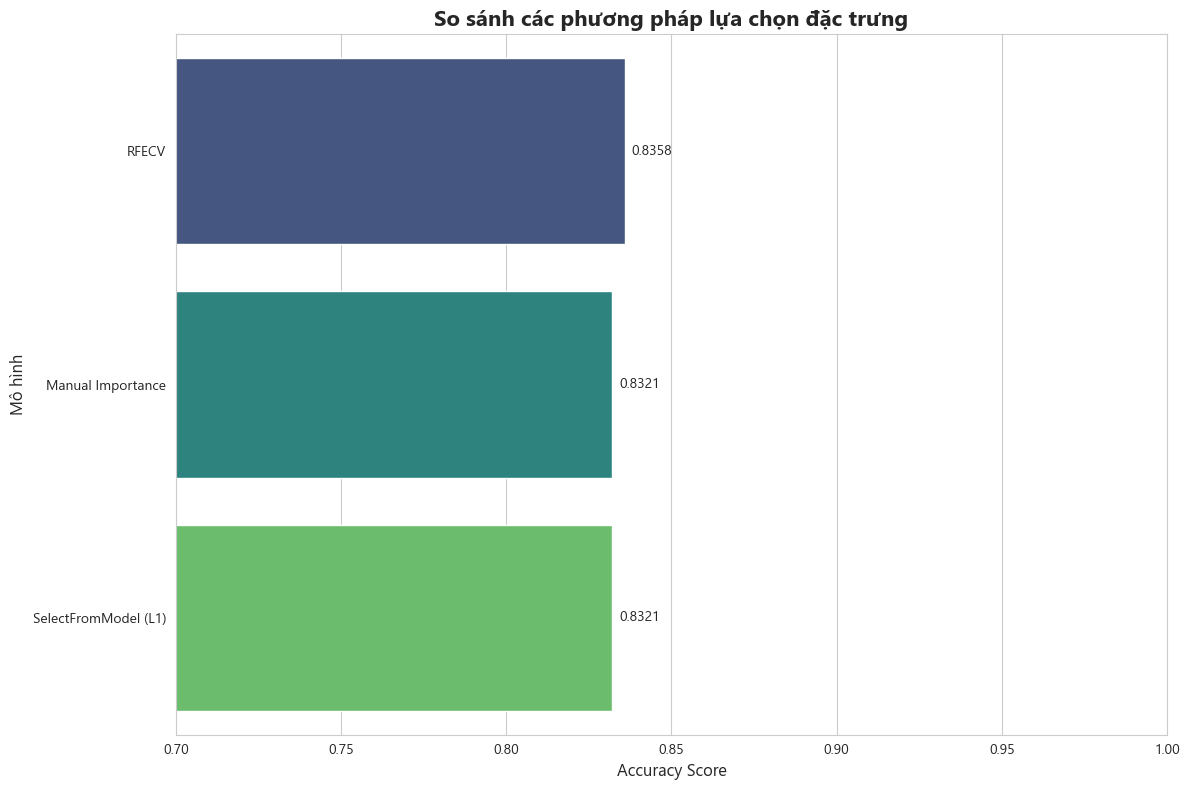

In [29]:
# =============================================================================
# 3. SO SÁNH CÁC PHƯƠNG PHÁP LOẠI BỎ ĐẶC TRƯNG
# =============================================================================
print("\n--- BƯỚC 3: SO SÁNH CÁC PHƯƠNG PHÁP LOẠI BỎ ĐẶC TRƯNG ---")
print(f"Sử dụng mô hình '{best_baseline_model_name}' để đánh giá các phương pháp lựa chọn đặc trưng.")

# Chuẩn bị dữ liệu (scale trước để dùng cho các phương pháp)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

best_model_estimator = models[best_baseline_model_name]
feature_selection_results = []

# --- Phương pháp 1: Manual Selection (dựa trên Feature Importance) ---
print("\n[1] Phương pháp: Manual Selection (dựa trên Importance)")
model_for_importance = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
importances_df = pd.DataFrame({
    'feature': X_train.columns, 'importance': model_for_importance.feature_importances_
}).sort_values('importance', ascending=False)
plot_feature_importance(importances_df)

features_to_drop_manual = importances_df.tail(3)['feature'].tolist() # Loại bỏ 3 features yếu nhất
X_train_manual = X_train.drop(columns=features_to_drop_manual)
X_validation_manual = X_validation.drop(columns=features_to_drop_manual)

best_model_estimator.fit(scaler.fit_transform(X_train_manual), y_train)
acc_manual = accuracy_score(y_validation, best_model_estimator.predict(scaler.transform(X_validation_manual)))
feature_selection_results.append({'Giai đoạn': 'Feature Selection', 'Phương pháp': 'Manual Importance', 'Số features': X_train_manual.shape[1], 'Accuracy': acc_manual})
print(f"Accuracy với Manual Selection: {acc_manual:.4f} ({X_train_manual.shape[1]} features)")

# --- Phương pháp 2: RFECV (Recursive Feature Elimination with CV) ---
print("\n[2] Phương pháp: RFECV (Tìm số features tối ưu tự động)")
rfecv_selector = RFECV(estimator=best_model_estimator, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv_selector.fit(X_train_scaled, y_train)

print(f"RFECV tìm thấy số features tối ưu là: {rfecv_selector.n_features_}")
X_train_rfecv = rfecv_selector.transform(X_train_scaled)
X_validation_rfecv = rfecv_selector.transform(X_validation_scaled)

best_model_estimator.fit(X_train_rfecv, y_train)
acc_rfecv = accuracy_score(y_validation, best_model_estimator.predict(X_validation_rfecv))
feature_selection_results.append({'Giai đoạn': 'Feature Selection', 'Phương pháp': 'RFECV', 'Số features': rfecv_selector.n_features_, 'Accuracy': acc_rfecv})
print(f"Accuracy với RFECV: {acc_rfecv:.4f} ({rfecv_selector.n_features_} features)")

# --- Phương pháp 3: SelectFromModel (dựa trên L1/Lasso) ---
print("\n[3] Phương pháp: SelectFromModel (với L1/Lasso)")
l1_selector_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
sfm_selector = SelectFromModel(estimator=l1_selector_model, prefit=False)
sfm_selector.fit(X_train_scaled, y_train)

X_train_sfm = sfm_selector.transform(X_train_scaled)
X_validation_sfm = sfm_selector.transform(X_validation_scaled)

print(f"SelectFromModel giữ lại {X_train_sfm.shape[1]} features.")
best_model_estimator.fit(X_train_sfm, y_train)
acc_sfm = accuracy_score(y_validation, best_model_estimator.predict(X_validation_sfm))
feature_selection_results.append({'Giai đoạn': 'Feature Selection', 'Phương pháp': 'SelectFromModel (L1)', 'Số features': X_train_sfm.shape[1], 'Accuracy': acc_sfm})
print(f"Accuracy với SelectFromModel: {acc_sfm:.4f} ({X_train_sfm.shape[1]} features)")

# Trực quan hóa so sánh các phương pháp lựa chọn đặc trưng
fs_df = pd.DataFrame(feature_selection_results)
plot_model_comparison(fs_df.rename(columns={'Phương pháp': 'Mô hình'}), 'So sánh các phương pháp lựa chọn đặc trưng')

In [30]:
# =============================================================================
# 4. SO SÁNH VỚI ĐIỀU CHỈNH SIÊU THAM SỐ (HYPERPARAMETER TUNING)
# =============================================================================
print("\n--- BƯỚC 4: ĐIỀU CHỈNH SIÊU THAM SỐ ---")
print(f"Thực hiện GridSearch cho mô hình: {best_baseline_model_name}")

param_grids = {
    "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10], 'model__min_samples_leaf': [1, 2]},
    "Gradient Boosting": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5]},
    "Support Vector Machine": {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']},
    "Logistic Regression": {'model__C': [0.1, 1, 10], 'model__solver': ['liblinear']},
    "KNN": {'model__n_neighbors': [3, 5, 7, 9]}
}
param_grid = param_grids.get(best_baseline_model_name)

if param_grid:
    pipeline_for_tuning = Pipeline([('scaler', StandardScaler()), ('model', models[best_baseline_model_name])])
    grid_search = GridSearchCV(pipeline_for_tuning, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train) # Dùng bộ đặc trưng đã chọn
    print(f"\nTham số tốt nhất tìm được: {grid_search.best_params_}")
    
    best_model_tuned = grid_search.best_estimator_
    y_pred_tuned = best_model_tuned.predict(X_validation_selected)
    accuracy_tuned = accuracy_score(y_validation, y_pred_tuned)

    results.append({"Thử nghiệm": "Điều chỉnh siêu tham số", "Mô hình": best_baseline_model_name, "Accuracy": accuracy_tuned})
    print(f"Accuracy sau khi điều chỉnh siêu tham số: {accuracy_tuned:.4f}")
else:
    print(f"Bỏ qua GridSearch vì không có param_grid được định nghĩa cho {best_baseline_model_name}.")



--- BƯỚC 4: ĐIỀU CHỈNH SIÊU THAM SỐ ---
Thực hiện GridSearch cho mô hình: Logistic Regression



Tham số tốt nhất tìm được: {'model__C': 1, 'model__solver': 'liblinear'}
Accuracy sau khi điều chỉnh siêu tham số: 0.8246
